In [5]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 29.5 MB/s 
     |████████████████████████████████| 212 kB 75.4 MB/s 


### Importing Libraries:

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nlp 
import random

### Functions to plot the graphs and confusion matrix:

In [59]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


### Loading the dataset:

In [8]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


### Setting the training and the testing dataset:

In [9]:
train=dataset['train']
validation=dataset['validation']
test=dataset['test']

In [10]:
def get_tweets(dataset):
  tweets=[x['text'] for x in dataset]
  labels=[x['label'] for x in dataset]
  return tweets,labels

In [11]:
tweets,labels=get_tweets(train)

In [12]:
tweets[0]

'i didnt feel humiliated'

### Tokenizing the data

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')

In [15]:
tokenizer.fit_on_texts(tweets)

In [16]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

### Checking the length of the tweets:

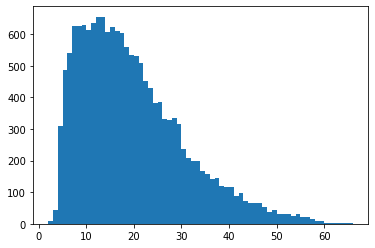

In [19]:
lengths =[len(x.split(' ')) for x in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

We can see from the graph that the maximum number of tweets contain 10 to 20 words while only some tweets contains words more than 50

### Padding the tweets to a length

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
maxlen=50

def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [22]:
padded_train_sequences=get_sequences(tokenizer,tweets)

In [23]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [88]:
classes=set(labels)
classes


{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

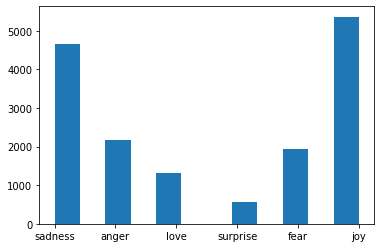

In [33]:
plt.hist(labels,bins=12)
plt.show()

In [35]:
tolabels=dict((j,i) for i,j in enumerate(classes))
toclasses=dict((v,k) for k,v in tolabels.items())

In [36]:
tolabels

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 5, 'surprise': 4}

In [37]:
toclasses

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'surprise', 5: 'sadness'}

In [39]:
train_labels_func=lambda labels:np.array([tolabels.get(x) for x in labels])

In [40]:
train_labels=train_labels_func(labels)

### Model Architecture:

In [48]:
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(10000,16,input_length=maxlen),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                           tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [68]:
val_tweets,val_labels=get_tweets(validation)
val_sequences=get_sequences(tokenizer,val_tweets)
val_lables=train_labels_func(val_labels)

In [69]:
val_tweets[0],val_lables[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

### Fitting the model:

In [57]:
h=model.fit(
    padded_train_sequences,train_labels,
    validation_data=(val_sequences,val_lables),
    epochs=25,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/25
500/500 [==============================] - 17s 16ms/step - loss: 1.3048 - accuracy: 0.4799 - val_loss: 0.8287 - val_accuracy: 0.6920
Epoch 2/25
500/500 [==============================] - 7s 13ms/step - loss: 0.5704 - accuracy: 0.7942 - val_loss: 0.5960 - val_accuracy: 0.8220
Epoch 3/25
500/500 [==============================] - 7s 13ms/step - loss: 0.3044 - accuracy: 0.9023 - val_loss: 0.3911 - val_accuracy: 0.8730
Epoch 4/25
500/500 [==============================] - 7s 13ms/step - loss: 0.1971 - accuracy: 0.9376 - val_loss: 0.3687 - val_accuracy: 0.8865
Epoch 5/25
500/500 [==============================] - 7s 14ms/step - loss: 0.1520 - accuracy: 0.9507 - val_loss: 0.4134 - val_accuracy: 0.8820
Epoch 6/25
500/500 [==============================] - 7s 14ms/step - loss: 0.1222 - accuracy: 0.9616 - val_loss: 0.3514 - val_accuracy: 0.8970
Epoch 7/25
500/500 [==============================] - 7s 14ms/step - loss: 0.0991 - accuracy: 0.9691 - val_loss: 0.3683 - val_accuracy: 0.892

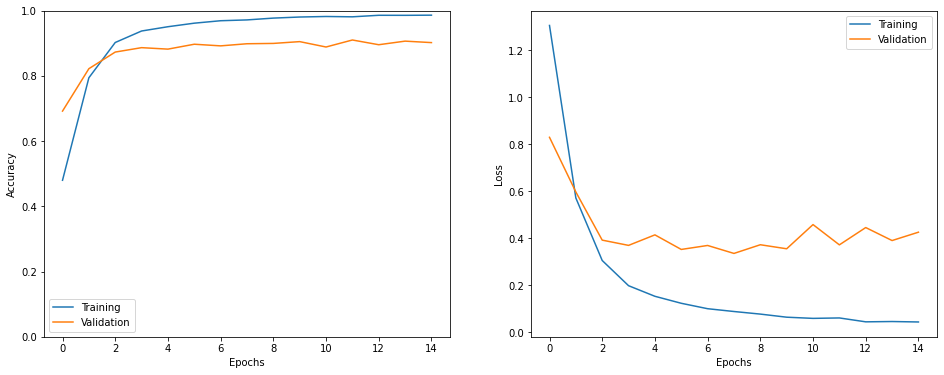

In [61]:
show_history(h)

In [70]:
test_tweets,test_labels=get_tweets(test)
test_sequences=get_sequences(tokenizer,test_tweets)
test_labels=train_labels_func(test_labels)

In [71]:
test_tweets[0],test_labels[0]

('im feeling rather rotten so im not very ambitious right now', 5)

In [72]:
_=model.evaluate(test_sequences,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4642 - accuracy: 0.8885


In [81]:
i=random.randint(0,len(test_labels)-1)
print('Sentence:',test_tweets[i])
print('Emotion:',toclasses[test_labels[i]])

p=model.predict(np.expand_dims(test_sequences[i],axis=0))[0]
pred_class= toclasses[np.argmax(p).astype('uint8')]
print('Predicted Emotion:',pred_class)

Sentence: i said i feel ugly today
Emotion: sadness
Predicted Emotion: sadness


In [87]:
predict=model.predict(test_sequences) 
classes_pred=np.argmax(predict,axis=1)

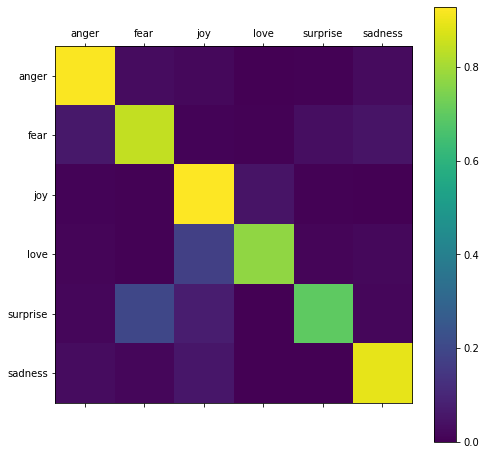

In [89]:
show_confusion_matrix(test_labels,classes_pred,list(classes))